# **Interpretable AI For Protein Expression Images and Associated Clinical Metadata (VGG16 for multi-channel stacked protein images)**

## **1. Introduction**

With a conservative frequency estimate of about 1:5,000, mitochondrial disorders are among the most prevalent inheritable diseases [1]. Diagnosis and understanding of the different mitochondrial diseases are extremely difficult because they have a wide range of symptoms in each patient and affect different organs and tissues of the body [2]. However, recent studies show deep learning algorithms with interpretability and explainability, especially Convolutional Neural Networks (CNN), can help us automatically diagnose and evaluate different diseases by detecting the different patterns in the images. In the study, we developed deep learning models using transfer learning to predict mitochondrial diseases and used existing machine learning interpretability and explainability AI approaches for computer vision, like Grad-CAM [3], and Neural Disentanglement (concept whitening) [4], to understand the features that result in the prediction of mitochondrial disease from protein expression images.

## **2. Aim**

To determine if Deep Learning (DL) can be used as a reliable method to classify mitochondrial diseases using interpretability
and explainability approaches.

• Interpretability Method: Neural Disentanglement

• Explainability Method: Saliency Map 

## **3. Objective**

This investigation has primarily two objectives:

Determine whether it is possible to accurately diagnose mitochondrial diseases for multi-channel stacked protein images.

>  Adapt the pre-trained deep learning models like VGG16 and ResNet-50 to classify different mitochondrial diseases using protein expression images obtained by image mass cytometry.     

>  Evaluate, compare, and fine-tune different pre-trained model architectures using parameters like accuracy, precision, recall, f1 score, and confusion matrix.



#**Introduction**

#**Importing essential libraries**

In [1]:
# initiating gpu using tensorflow.
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5



In [2]:
import numpy as np
import pandas as pd
import glob
import random 
import os
import cv2
from shutil import copy,copytree
import shutil

!pip install patchify
from patchify import patchify

from google.colab import files
import os
import zipfile

#visulaziation
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow


# image
from PIL import Image

# sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
#tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img,img_to_array
from tensorflow.keras.applications import VGG16, InceptionV3, ResNet101V2, Xception, ResNet50V2, VGG19
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras import models, layers
from keras.utils.vis_utils import plot_model
from tensorflow.keras.layers import Dense,Conv2D,MaxPool2D,Flatten,Dropout,BatchNormalization,Activation,GlobalAveragePooling2D

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

#setting seed to reproduce the same result every time the code is re-run
seed_num = 1
tf.random.set_seed(seed_num)
np.random.seed(seed_num)

# install split-folder
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Unziping the dataset**

In [5]:
%%capture
!unzip /content/drive/MyDrive/Dataset.zip

#**Data Engineering**
**Renaming all the files in the subfolder for both control and patient with subfolder names**

In [6]:
d = ["/content/Dataset/controls/C01","/content/Dataset/controls/C02","/content/Dataset/controls/C03","/content/Dataset/controls/C04"]
for i in d:
  for path in os.listdir(i):
      full_path = os.path.join(i, path)
      if os.path.isfile(full_path):
          new_path = os.path.join(i, "C0"+str(d.index(i)+1)+"_"+ path)
          os.rename(full_path, new_path)

In [7]:
d = ["/content/Dataset/patients/P01","/content/Dataset/patients/P02","/content/Dataset/patients/P03","/content/Dataset/patients/P04","/content/Dataset/patients/P05","/content/Dataset/patients/P06","/content/Dataset/patients/P07","/content/Dataset/patients/P08","/content/Dataset/patients/P09","/content/Dataset/patients/P10"]
for i in d:
  for path in os.listdir(i):
      full_path = os.path.join(i, path)
      if os.path.isfile(full_path):
          new_path = os.path.join(i, "P0"+str(d.index(i)+1)+"_" + path)
          os.rename(full_path, new_path)

**Copying all the JPG images into Dataset_JPG directory and maintaing the tree structure of the directories**

In [8]:
shutil.copytree('/content/Dataset', '/content/Dataset_JPG' , ignore=shutil.ignore_patterns('*.ome.tiff', '*.db'))

'/content/Dataset_JPG'

**Copying all the TIFF images into Dataset_TIFF directory and maintaing the tree structure of the directories**

In [9]:
shutil.copytree('/content/Dataset', '/content/Dataset_TIFF' , ignore=shutil.ignore_patterns('*.jpg', '*.db'))

'/content/Dataset_TIFF'

#**Combining Multiple Images into single images**

**Combing/stacking all the Control and pateints Images with different proteins of different Control and patients into single Image using NP Concatenate process.**

In [10]:
def channel_merger(img_list): # img_list need to be list of images of all protein expression images of a subject 
    
    multi_channel_img = np.zeros((*img_list[0].shape,len(img_list)), np.uint8)
    
    for i, img in enumerate(img_list):
        multi_channel_img[:,:,i]= img
        
    return multi_channel_img

**For Control**

In [11]:
from glob import glob
import numpy as np
from tifffile import imread,imwrite
newpath = r'/content/TIFF_Images_Concat/Controls/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
for i in range(1,5):
  X = sorted(glob('/content/Dataset_TIFF/controls/C*'+str(i)+'/*.tiff'))
  X = list(map(imread,X))
  multi_channel_img= channel_merger(X)
  #multi_channel_img = np.transpose(multi_channel_img)
  #multi_stack_image = Image.fromarray(multi_channel_img)
  np.save(str(newpath) + 'C0'+str(i)+'_combined.npy' ,multi_channel_img)

**For Patient**

In [12]:
from glob import glob
import numpy as np
from tifffile import imread,imwrite
newpath = r'/content/TIFF_Images_Concat/Patients/' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
for i in range(1,11):
  X = sorted(glob('/content/Dataset_TIFF/patients/P*'+str(i)+'/*.tiff'))
  X = list(map(imread,X))
  multi_channel_img= channel_merger(X)
  #multi_channel_img = np.transpose(multi_channel_img)
  np.save(str(newpath) + 'P0'+str(i)+'_combined.npy' ,multi_channel_img)


**Spliting the numpy array into multiple array using patchify function**

**For control:**

In [13]:
import glob
#Creating a new path to store all splitting jpg images
newpath = r'/content/Concat_Split_Images/Controls' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
my_path = "/content/TIFF_Images_Concat/Controls"
files = glob.glob(my_path + '/**/*.npy', recursive=True)
for file in files:
  img = np.load(file)
  patches_img = patchify(img, (512,512,10), step=256)
  for i in range(patches_img.shape[0]):
      for j in range(patches_img.shape[1]):
          single_patch_img = patches_img[i, j, 0, :, :, :]
          np.save('/content/Concat_Split_Images/Controls/' + "C0"+str(files.index(file)+1)+'_image_' + '_'+ str(i)+str(j)+'.npy', single_patch_img)            

**For Patients**

In [14]:
#Creating a new path to store all spliting jpg images
import glob
newpath = r'/content/Concat_Split_Images/Patients' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
my_path = "/content/TIFF_Images_Concat/Patients"
files = glob.glob(my_path + '/**/*.npy', recursive=True)
for file in files:
  img = np.load(file)
  patches_img = patchify(img, (512,512,10), step=256)
  for i in range(patches_img.shape[0]):
      for j in range(patches_img.shape[1]):
          single_patch_img = patches_img[i, j, 0, :, :, :]
          np.save('/content/Concat_Split_Images/Patients/' + "P0"+str(files.index(file)+1)+'_image_' + '_'+ str(i)+str(j)+'.npy', single_patch_img)

**Storing the numpy files in dataframe**

In [ ]:
import os
import pandas as pd

os.chdir(r'/content/Concat_Split_Images')

folders = ['Controls', 'Patients']

files = []

for folder in folders:
    for file in os.listdir(folder):
        files.append([str('/content/Concat_Split_Images/')+folder+str('/')+file, folder])

pd.DataFrame(files, columns=['files', 'target']).to_csv('files_and_targets_1.csv')

**Loading the CSV file:**

In [ ]:
df=pd.read_csv('/content/Concat_Split_Images/files_and_targets_1.csv')

In [ ]:
df.head()

,Unnamed: 0,files,target
0,0,/content/Concat_Split_Images/Controls/C01_imag...,Controls
1,1,/content/Concat_Split_Images/Controls/C04_imag...,Controls
2,2,/content/Concat_Split_Images/Controls/C04_imag...,Controls
3,3,/content/Concat_Split_Images/Controls/C02_imag...,Controls
4,4,/content/Concat_Split_Images/Controls/C04_imag...,Controls


**Label encoding the traget variable:**

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
#num_classes = 2
df['category'] = labelencoder.fit_transform(df['target'])
df

,Unnamed: 0,files,target,category
0,0,/content/Concat_Split_Images/Controls/C01_imag...,Controls,0
1,1,/content/Concat_Split_Images/Controls/C01_imag...,Controls,0
2,2,/content/Concat_Split_Images/Controls/C01_imag...,Controls,0
3,3,/content/Concat_Split_Images/Controls/C01_imag...,Controls,0
4,4,/content/Concat_Split_Images/Controls/C01_imag...,Controls,0
...,...,...,...,...
944,944,/content/Concat_Split_Images/Patients/P01_imag...,Patients,1
945,945,/content/Concat_Split_Images/Patients/P07_imag...,Patients,1
946,946,/content/Concat_Split_Images/Patients/P07_imag...,Patients,1
947,947,/content/Concat_Split_Images/Patients/P07_imag...,Patients,1


**Creating a column image and Stroing the files names as numpy array:**

In [ ]:
df['image']=df['files'].map(lambda x: np.load(x))

##**Feature and Target Split**

In [ ]:
features=df['image']
target=df['category']

**Training, Validation and Test Split**

We first split the dataset to 80% training data and 20% testing data. We then take the 80% training data and split it into 87.5% training data and 12.5% validation data, to form our 70% Training - 10% Validation - 20% Testing. Note that the split will be applied across each class individually to ensure there is enough samples from each class in each split for accurate modeling, meaning each class will be split 70:10:20 as well. This is done by setting 'stratify' in train_test_split function to our target.

Training: 80% 87.5% = 70% Validation: 80% 12.5% = 10% Testing: 20%

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(features,target,test_size=0.20,stratify=target)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, stratify=y_train)

**Target One-Hot Encoding**

Creating one-hot vectors of size (1,2) for each label



In [ ]:
from keras.utils.np_utils import to_categorical
num_classes = 2
y_train = to_categorical(y_train, num_classes = 2)
y_test = to_categorical(y_test, num_classes = 2)
y_val = to_categorical(y_val, num_classes = 2)

**Converting numarry into tensor**

In [ ]:
X_train_normal = np.asarray(X_train.tolist())
X_test_normal = np.asarray(X_test.tolist())
X_val_normal=np.asarray(X_val.tolist())

In [ ]:
input_shape=(512,512,10)
X_train_normal=X_train_normal.reshape(X_train_normal.shape[0],*(input_shape))
X_test_normal=X_test_normal.reshape(X_test_normal.shape[0],*(input_shape))
X_val_normal=X_val_normal.reshape(X_val_normal.shape[0],*(input_shape))

In [ ]:
X_train_normal[0].shape

(512, 512, 10)

**Converting the numpy array into Tiff Images.**

**For Controls**

In [ ]:
newpath = r'/content/Concat_Split_Images_Convert_TIFF/Controls' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
my_path = "/content/Concat_Split_Images/Controls/"
files = glob.glob(my_path + '/**/*.npy', recursive=True)
for file in files:
  img=np.transpose(np.load(file))
  imwrite('/content/Concat_Split_Images_Convert_TIFF/Controls/' + "C0"+str(file[38:57])+'_image_'+'.tiff',img)

**For Patients**

In [ ]:
newpath = r'/content/Concat_Split_Images_Convert_TIFF/Patients' 
if not os.path.exists(newpath):
    os.makedirs(newpath)
files = glob.glob(my_path + '/**/*.npy', recursive=True)
my_path = "/content/Concat_Split_Images/Patients/"
for file in files:
  img=np.transpose(np.load(file))
  #print(str(file[38:57]))
  imwrite('/content/Concat_Split_Images_Convert_TIFF/Patients/' + "P0"+str(file[38:57])+'_image_'+'.tiff',img)

#**Building the model**
**Transfer Learning Using VGG16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from keras.backend import dropout
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten

In [ ]:
#Import vgg model  
vgg_model = VGG16(include_top=False, weights='imagenet',classes=2)
print(vgg_model.summary())

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

In [ ]:
#Get the dictionary of config for vgg16
vgg_config = vgg_model.get_config()

In [ ]:
# Change the input shape to new desired shape
h, w, c = 512, 512, 10
vgg_config["layers"][0]["config"]["batch_input_shape"] = (None, h, w, c)

In [ ]:
#Create new model with the updated configuration
vgg_updated = Model.from_config(vgg_config)
print(vgg_updated.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 10)]    0         
                                                                 
 block1_conv1 (Conv2D)       (None, 512, 512, 64)      5824      
                                                                 
 block1_conv2 (Conv2D)       (None, 512, 512, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 256, 256, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 256, 256, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 256, 256, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 128, 128, 128)     0     

In [ ]:
# Check Weights of first conv layer in the original model...
orig_model_conv1_block1_wts = vgg_model.layers[1].get_weights()[0]

In [ ]:
# Check Weights of first conv layer in the new model...
new_model_conv1_block1_wts = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts[:,:,0,0])
print(new_model_conv1_block1_wts[:,:,1,0])
print(new_model_conv1_block1_wts[:,:,2,0])
print(new_model_conv1_block1_wts[:,:,3,0])
print(new_model_conv1_block1_wts[:,:,4,0])

[[ 0.02829569  0.03168283  0.0033508 ]
 [-0.06086812  0.04507653  0.06257006]
 [ 0.05465942 -0.00948675  0.0658249 ]]
[[ 0.08011047  0.0014619   0.00804241]
 [ 0.08974328 -0.04196398  0.07549677]
 [ 0.00155719 -0.03806409  0.09417938]]
[[ 0.07801598 -0.08924396  0.04402944]
 [ 0.01371067  0.08697736 -0.02134985]
 [ 0.01825546  0.03231918  0.04109228]]
[[-0.006535    0.05333578  0.00038444]
 [-0.00677782  0.07979659  0.00941026]
 [ 0.03664634 -0.03211647 -0.05460119]]
[[ 0.00129946  0.00180526  0.03406311]
 [-0.03177553 -0.01161928 -0.04412477]
 [-0.09214511  0.04294144  0.01965515]]


In [ ]:
# Function that calculates average of weights along the channel axis and then
#copies it over n number of times. n being the new channels that need to be concatenated with the original channels. 
def avg_and_copy_wts(weights, num_channels_to_fill):  #num_channels_to_fill are the extra channels for which we need to fill weights
  average_weights = np.mean(weights, axis=-2).reshape(weights[:,:,-1:,:].shape)  #Find mean along the channel axis (second to last axis)
  wts_copied_to_mult_channels = np.tile(average_weights, (num_channels_to_fill, 1)) #Repeat (copy) the array multiple times
  return(wts_copied_to_mult_channels)

In [ ]:
#Get the configuration for the updated model and extract layer names. 
 
vgg_updated_config = vgg_updated.get_config()
vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

In [ ]:
first_conv_name = vgg_updated_layer_names[1]

In [ ]:
#Update weights for all layers. And for the first conv layer, copy the first
#three layer weights and fill others with the average of all three. 
for layer in vgg_model.layers:
    if layer.name in vgg_updated_layer_names:
     
      if layer.get_weights() != []:  #All convolutional layers and layers with weights (no input layer or any pool layers)
        target_layer = vgg_updated.get_layer(layer.name)
    
        if layer.name in first_conv_name:    #For the first convolutionl layer
          weights = layer.get_weights()[0]
          biases  = layer.get_weights()[1]
    
          weights_extra_channels = np.concatenate((weights,   #Keep the first 3 channel weights as-is and copy the weights for additional channels.
                                                  avg_and_copy_wts(weights, c - 3)),  # - 3 as we already have weights for the 3 existing channels in our model. 
                                                  axis=-2)
                                                  
          target_layer.set_weights([weights_extra_channels, biases])  #Now set weights for the first conv. layer
          target_layer.trainable = False   #You can make this trainable if you want. 
    
        else:
          target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
          target_layer.trainable = False  #You can make this trainable if you want.

In [ ]:
# Check Weights of first conv layer in the new model...
#Compare against the original model weights
new_model_conv1_block1_wts_updated = vgg_updated.layers[1].get_weights()[0]
print(new_model_conv1_block1_wts_updated[:,:,0,0])
print(new_model_conv1_block1_wts_updated[:,:,1,0])
print(new_model_conv1_block1_wts_updated[:,:,2,0])
print(new_model_conv1_block1_wts_updated[:,:,5,0])
print(new_model_conv1_block1_wts_updated[:,:,8,0])

[[ 0.42947057  0.373467   -0.06136011]
 [ 0.27476987  0.03868078 -0.36722335]
 [-0.05746817 -0.26224968 -0.35009676]]
[[ 0.55037946  0.44007453 -0.08138704]
 [ 0.34573907  0.04063221 -0.4535013 ]
 [-0.05863491 -0.33066967 -0.4850302 ]]
[[ 0.4800154   0.4085474  -0.06514555]
 [ 0.31047726  0.05020237 -0.40338343]
 [-0.05087169 -0.2852275  -0.41851634]]
[[ 0.48662183  0.40736297 -0.06929757]
 [ 0.31032872  0.04317178 -0.40803602]
 [-0.05565825 -0.29271564 -0.4178811 ]]
[[ 0.48662183  0.40736297 -0.06929757]
 [ 0.31032872  0.04317178 -0.40803602]
 [-0.05565825 -0.29271564 -0.4178811 ]]


In [ ]:
#instantiate a base model with pre-trained weights.
base_model=vgg_updated

In [ ]:
#freeze the base model
base_model.trainable = False

In [ ]:
#Create new model on top
model=Sequential()
model.add(base_model)
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(2, activation='softmax'))

In [ ]:
optim=Adam(learning_rate=0.001)
model.compile(loss='binary_crossentropy',metrics=['accuracy'],optimizer=optim)
print("Model compilation completed.")

Model compilation completed.


In [ ]:
callbacks = [EarlyStopping(monitor='val_accuracy',patience=30)]

In [ ]:
history = model.fit(X_train_normal,y_train,batch_size=2,
                                       epochs=100,
                                       validation_data=(X_val_normal,y_val),callbacks=callbacks)

Epoch 1/100
304/304 [==============================] - 45s 103ms/step - loss: 0.5361 - accuracy: 0.8880 - val_loss: 0.3552 - val_accuracy: 0.9539
Epoch 2/100
304/304 [==============================] - 34s 111ms/step - loss: 0.2389 - accuracy: 0.9555 - val_loss: 0.1020 - val_accuracy: 0.9737
Epoch 3/100
304/304 [==============================] - 34s 111ms/step - loss: 0.1780 - accuracy: 0.9736 - val_loss: 0.1906 - val_accuracy: 0.9539
Epoch 4/100
304/304 [==============================] - 34s 110ms/step - loss: 0.1362 - accuracy: 0.9802 - val_loss: 1.3006 - val_accuracy: 0.8026
Epoch 5/100
304/304 [==============================] - 28s 94ms/step - loss: 0.2760 - accuracy: 0.9621 - val_loss: 0.1142 - val_accuracy: 0.9737
Epoch 6/100
304/304 [==============================] - 34s 111ms/step - loss: 0.0276 - accuracy: 0.9967 - val_loss: 0.2336 - val_accuracy: 0.9737
Epoch 7/100
304/304 [==============================] - 33s 110ms/step - loss: 0.0920 - accuracy: 0.9753 - val_loss: 0.0998 - 

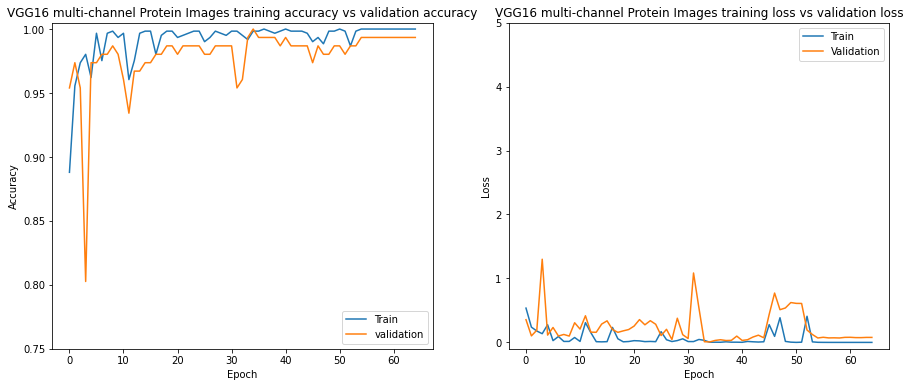

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('VGG16 multi-channel Protein Images training accuracy vs validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim((0.75,1.005))
plt.legend(['Train', 'validation'], loc='lower right')


# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('VGG16 multi-channel Protein Images training loss vs validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.ylim((-0.10,5))
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

##**Predictions**

In [ ]:
# Generate generalization metrics
score = model.evaluate(X_test_normal,y_test,verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.1664576530456543 / Test accuracy: 0.9842105507850647


**Saving the model**

The saved full model file includes:

The model's architecture,The model's weight values

In [ ]:
model.save('/content/drive/MyDrive/Saliency_Maps_Stacked_Images/VGG16_Concat_Proteins.h5')
print("saved the model")

saved the model


**Loading the model**

In [16]:
model_loaded = load_model("/content/drive/MyDrive/Saliency_Maps_Stacked_Images/VGG16_Concat_Proteins.h5")

#**Predictions**

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
import math
y_true_classes = np.argmax(y_test, axis = 1)
#print(y_true_classes)
y_pred = model.predict(X_test_normal)
yhat_classes = np.argmax(y_pred,axis=1) 
#print(yhat_classes) 

**Accuracy,precision,recall values and f1 score**

In [ ]:
accuracy_VGG16=accuracy_score(y_true_classes,yhat_classes)
print("Accuracy: %f" % accuracy_VGG16)
precision_VGG16=precision_score(y_true_classes,yhat_classes,average='weighted')
print("Precision: %f" % precision_VGG16)
recall_VGG16=recall_score(y_true_classes,yhat_classes,average='weighted')
print("Recall: %f" % recall_VGG16)
VGG16_F1_score=f1_score(y_true_classes,yhat_classes,average='weighted')
print("F1_score: %f" % VGG16_F1_score)

Accuracy: 0.984211
Precision: 0.984533
Recall: 0.984211
F1_score: 0.984026


In [ ]:
from sklearn.metrics import confusion_matrix

confusion_mat = confusion_matrix(y_true_classes, yhat_classes>0.5)

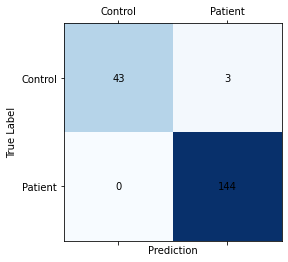

<Figure size 1080x720 with 0 Axes>

In [ ]:
fig, ax = plt.subplots()

ax.matshow(confusion_mat, cmap=plt.cm.Blues)

ax.set_xlabel('Prediction')
ax.set_ylabel('True Label')

tick_labels = ['Control', 'Patient']

ax.set_xticks(range(len(tick_labels)))
ax.set_yticks(range(len(tick_labels)))
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

for i in range(len(tick_labels)):
    for j in range(len(tick_labels)):
        ax.text(j, i, confusion_mat[i, j],
               ha='center', va='center')
        
plt.figure(figsize=(15,10))
plt.show()

**Random Prediction**

**For Control:**

In [24]:
test_numpy_1=np.load('/content/drive/MyDrive/Saliency_Maps_Stacked_Images/Testing/C02_image__711.npy')
test_np_1=np.asarray(test_numpy_1.tolist())
test_np_1= test_np_1.reshape(1,512,512,10)
prediction_class = model_loaded.predict(test_np_1)
print("Predicted: {}".format(np.argmax(prediction_class)))

Predicted: 0


**For Patient**

In [25]:
test_numpy_1=np.load('/content/drive/MyDrive/Saliency_Maps_Stacked_Images/Testing/P01_image__47.npy')
test_np_1=np.asarray(test_numpy_1.tolist())
test_np_1= test_np_1.reshape(1,512,512,10)
prediction_class = model_loaded.predict(test_np_1)
print("Predicted: {}".format(np.argmax(prediction_class)))

Predicted: 1


**Random Prediction from Dataframe**

In [ ]:
test_numpy_1=df['image'][50]
test_numpy_2=df['image'][100]
test_numpy_3=df['image'][400]
test_numpy_4=df['image'][768]

In [ ]:
test_np_1=np.asarray(test_numpy_1.tolist())
test_np_1= test_np_1.reshape(1,512,512,10)
test_np_2=np.asarray(test_numpy_2.tolist())
test_np_2= test_np_2.reshape(1,512,512,10)
test_np_3=np.asarray(test_numpy_3.tolist())
test_np_3= test_np_3.reshape(1,512,512,10)
test_np_4=np.asarray(test_numpy_4.tolist())
test_np_4= test_np_4.reshape(1,512,512,10)

In [ ]:
prediction_class = model.predict(test_np_1)
print("Actual:",df['category'][50])
print("Predicted: {}".format(np.argmax(prediction_class)))
prediction_class = model.predict(test_np_2)
print("Actual:",df['category'][100])
print("Predicted: {}".format(np.argmax(prediction_class)))
prediction_class = model.predict(test_np_3)
print("Actual:",df['category'][400])
print("Predicted: {}".format(np.argmax(prediction_class)))
prediction_class = model.predict(test_np_4)
print("Actual:",df['category'][768])
print("Predicted: {}".format(np.argmax(prediction_class)))

Actual: 0
Predicted: 0
Actual: 0
Predicted: 0
Actual: 1
Predicted: 1
Actual: 1
Predicted: 1


**!Thank you**